In [1]:
# Import required modules
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
# Read the data and use linear interpolation to fill the missing values
df = pd.read_csv("caiso_system_demand.csv", parse_dates=["time"]).set_index("time")
df.system_demand = df.system_demand.interpolate(limit_area="inside")

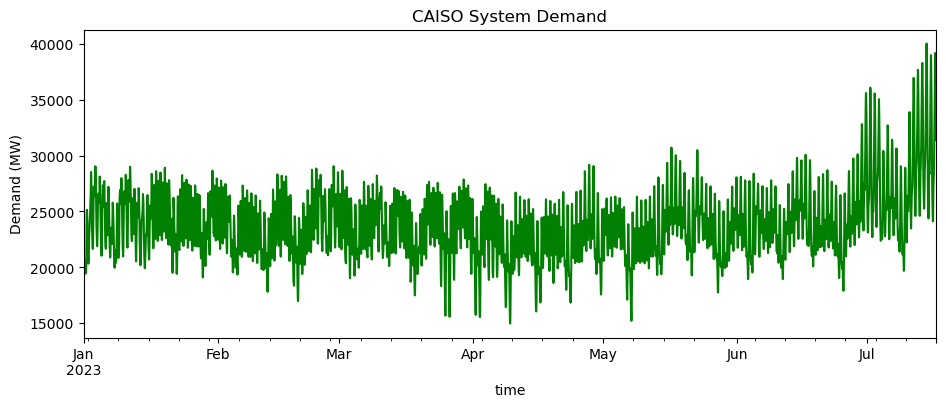

In [3]:
# Plot the data
fig, ax = plt.subplots(figsize=(11, 4))
df.system_demand.plot(ax=ax, color="g")
ax.set_title("CAISO System Demand")
ax.set_ylabel("Demand (MW)")
plt.show()

In [4]:
# Make TensorFlow reproducible by setting random seeds
tf.keras.utils.set_random_seed(43)  # sets seeds for base-python, numpy, and tf
tf.config.experimental.enable_op_determinism()

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[["system_demand"]])

# Prepare the data for LSTM
sequence_length = 24
X, y = [], []

# Create input sequences and corresponding target values
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length, 0])  # Extract the 1D array from the 2D array
    y.append(scaled_data[i+sequence_length, 0])   # Extract the target value

X = np.array(X)
y = np.array(y)

# Reshape X to have 3 dimensions (samples, sequence length, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(32, activation="relu", input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_absolute_error")

# Train the model
model.fit(X, y, epochs=30, batch_size=24)

# Generate forecasts for the next day (48 hours, considering each hour)
last_sequence = scaled_data[-sequence_length:]
forecast = []

# Predict the next 48 hours
for _ in range(48):
    last_sequence = last_sequence.reshape(1, sequence_length, 1)
    next_prediction = model.predict(last_sequence)[0][0]
    forecast.append(next_prediction)
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_prediction]]], axis=1)

# Inverse scale the forecast
forecast = pd.DataFrame(scaler.inverse_transform(np.array(forecast).reshape(-1, 1)), columns=["forecast"])
forecast["time"] = pd.date_range(start=df.index.max() + pd.Timedelta(hours=1), periods=48, freq="H")
forecast = forecast.set_index("time")

Epoch 1/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0958
Epoch 2/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0646
Epoch 3/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0479
Epoch 4/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0337
Epoch 5/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0229
Epoch 6/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0195
Epoch 7/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0192
Epoch 8/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0166
Epoch 9/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0165
Epoch 10/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0168
Epoch 11/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0149
Epoch 12/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0154
Epoch 13/30
196/196 [====

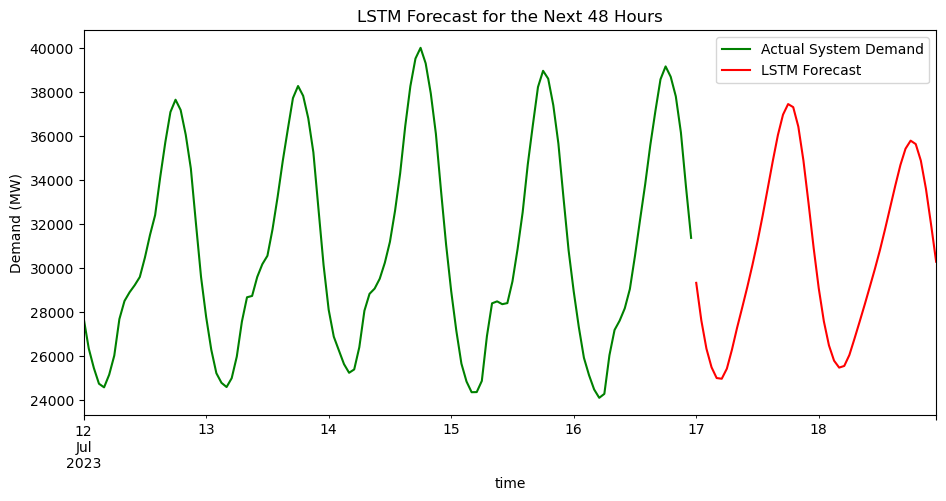

In [5]:
# Create a time index for the forecast
forecast_time_index = pd.date_range(start=df.index.max() + pd.Timedelta(hours=1), periods=48, freq="H")

# Plot the actual and forecast together
fig, ax = plt.subplots(figsize=(11, 5))
df.system_demand.tail(120).plot(ax=ax, label="Actual System Demand", color="g")
forecast.forecast.plot(ax=ax, label="LSTM Forecast", color="r")
ax.set_title("LSTM Forecast for the Next 48 Hours")
ax.set_ylabel("Demand (MW)")
ax.legend()
plt.show()